<h1>Table of Contents<span class="tocSkip"></span></h1>
<div class="toc"><ul class="toc-item"><li><span><a href="#Introduction-and-initial-setup" data-toc-modified-id="Introduction-and-initial-setup-1"><span class="toc-item-num">1&nbsp;&nbsp;</span>Introduction and initial setup</a></span></li><li><span><a href="#Astrometric-functions:" data-toc-modified-id="Astrometric-functions:-2"><span class="toc-item-num">2&nbsp;&nbsp;</span>Astrometric functions:</a></span></li><li><span><a href="#Data" data-toc-modified-id="Data-3"><span class="toc-item-num">3&nbsp;&nbsp;</span>Data</a></span><ul class="toc-item"><li><span><a href="#Coordinates-measurements" data-toc-modified-id="Coordinates-measurements-3.1"><span class="toc-item-num">3.1&nbsp;&nbsp;</span>Coordinates measurements</a></span></li><li><span><a href="#Known-system-orbital-parameters" data-toc-modified-id="Known-system-orbital-parameters-3.2"><span class="toc-item-num">3.2&nbsp;&nbsp;</span>Known system orbital parameters</a></span></li></ul></li><li><span><a href="#Model-1---Standard-fit:-two-dimensional-fit-to-the-measured-RA-and-Dec-values." data-toc-modified-id="Model-1---Standard-fit:-two-dimensional-fit-to-the-measured-RA-and-Dec-values.-4"><span class="toc-item-num">4&nbsp;&nbsp;</span>Model 1 - Standard fit: two-dimensional fit to the measured RA and Dec values.</a></span><ul class="toc-item"><li><span><a href="#Model-setup" data-toc-modified-id="Model-setup-4.1"><span class="toc-item-num">4.1&nbsp;&nbsp;</span>Model setup</a></span></li><li><span><a href="#Results-for-model-1" data-toc-modified-id="Results-for-model-1-4.2"><span class="toc-item-num">4.2&nbsp;&nbsp;</span>Results for model 1</a></span></li></ul></li><li><span><a href="#Model-2:-1-D-fit---One-dimensional-fit-perpendicular-to-the-jet-axis" data-toc-modified-id="Model-2:-1-D-fit---One-dimensional-fit-perpendicular-to-the-jet-axis-5"><span class="toc-item-num">5&nbsp;&nbsp;</span>Model 2: 1-D fit - One-dimensional fit perpendicular to the jet axis</a></span><ul class="toc-item"><li><span><a href="#Model-setup" data-toc-modified-id="Model-setup-5.1"><span class="toc-item-num">5.1&nbsp;&nbsp;</span>Model setup</a></span></li><li><span><a href="#Results-for-model-2" data-toc-modified-id="Results-for-model-2-5.2"><span class="toc-item-num">5.2&nbsp;&nbsp;</span>Results for model 2</a></span></li></ul></li><li><span><a href="#Producing-and-writing-final-reports:" data-toc-modified-id="Producing-and-writing-final-reports:-6"><span class="toc-item-num">6&nbsp;&nbsp;</span>Producing and writing final reports:</a></span></li><li><span><a href="#Comparisons" data-toc-modified-id="Comparisons-7"><span class="toc-item-num">7&nbsp;&nbsp;</span>Comparisons</a></span></li></ul></div>

# Impact of the jet on parallax and proper motion estimates for Cyg X-1

[**Miller-Jones et al., *submitted***]()

## Introduction and initial setup

In this notebook we try to estimate proper motion and source parallax (among other parameters) using a hierarchical bayesian  model constructed based on parameter constraints obtained from observations. We deploy this via [PyMC 3](https://docs.pymc.io/) ([Salvatier et al. 2016](https://doi.org/10.7717/peerj-cs.55)) package and use HMC ([Neal 2012](https://ui.adsabs.harvard.edu/?#abs/2012arXiv1206.1901N), [Betancourt 2017](https://ui.adsabs.harvard.edu/?#abs/2017arXiv170102434B)) with NUTS sampling ([Hoffman & Gelman 2011](https://ui.adsabs.harvard.edu/?#abs/2011arXiv1111.4246H)).

**Other packages used:**
- [Astropy](http://www.astropy.org/) ([Robitaille et al. 2013](https://ui.adsabs.harvard.edu/?#abs/2013A&A...558A..33A))
- [Corner](https://corner.readthedocs.io/en/latest/) ([Foreman-Mackey 2016](http://joss.theoj.org/papers/10.21105/joss.00024))
- [Matplotlib](https://matplotlib.org/) ([Hunter 2007](https://ieeexplore.ieee.org/document/4160265))
- [Numpy](http://www.numpy.org/) ([Oliphant 2006](https://archive.org/details/NumPyBook/page/n0))
- [Pandas](https://pandas.pydata.org/) ([McKinney 2010](http://conference.scipy.org/proceedings/scipy2010/mckinney.html))
- [Skyfield](http://rhodesmill.org/skyfield/)
- [Theano](http://deeplearning.net/software/theano/) ([Al-Rfou et al. 2016](https://ui.adsabs.harvard.edu/abs/2016arXiv160502688T/abstract); used through PyMC3)


In [1]:
import sys
import numpy as np
import astropy
import astropy.units as u
from astropy.coordinates import SkyCoord
from astropy.table import Table
import pymc3 as pm
import theano
import pandas as pd
import skyfield
from skyfield.api import Loader
import corner
import matplotlib.pyplot as plt
from matplotlib import rc

# Setting random seed:
rand_seed = np.random.randint(0, 2**32 - 1)
print('Random seed:',rand_seed)

# Plot settings:
rc('font',**{'family':'sans-serif','sans-serif':['Helvetica']})
rc('text', usetex=True)
rc('font', family='serif')

# Package versions:
print('Running on:')
print(f'\tPython:\t\t{sys.version[:5]}')
print('\tAstropy\t\t{}'.format(astropy.__version__))
print('\tCorner\t\t{}'.format(corner.__version__))
print('\tMatplotlib\t{}'.format(plt.matplotlib.__version__))
print('\tNumpy\t\t{}'.format(np.__version__))
print('\tPandas\t\t{}'.format(pd.__version__))
print('\tPyMC3\t\t{}'.format(pm.__version__))
print('\tSkyfield\t{}'.format(skyfield.__version__))
print('\tTheano\t\t{}'.format(theano.__version__))

%matplotlib inline

# Saving plots and tables produced in this file as separate files in the results folder
# if "past_chains" is true, no new simulations will be performed and the old ones will be read in
# Note: "saving = True"  overrules "past_chains = True", and new simulations will be performed and saved. 
saving = False
past_chains = True
prefix = 'CygX1_'

# Setting up a download folder for ephemeris files for skyfield:
load = Loader('/home/arash/astro_sw/skyfield-data')

Random seed: 3116870535
Running on:
	Python:		3.6.1
	Astropy		4.0
	Corner		2.0.1
	Matplotlib	3.1.3
	Numpy		1.18.1
	Pandas		0.25.3
	PyMC3		3.6
	Skyfield	1.10
	Theano		1.0.4


## Astrometric functions:

**Eart position at time t**<br/>
**`earth_position(t)`**

Using [NASA JPL Horizons database](https://ssd.jpl.nasa.gov/horizons.cgi) as implemented in python package [`skyfield`](http://rhodesmill.org/skyfield/), we obtain earth position $X_t$,$Y_t$,$Z_t$ at time $t$.

__

**Baseline midpoint**<br/>
**`t_0(t)`**
$$ t_0 = \text{min}(t) + \frac{\text{max}(t) - \text{min}(t)}{2} $$

For convenience, the reported value is rounded.

__

**Parallax components**<br/>
**`frac_parallax(t, alpha, delta)`**
$$f_{\alpha,t} = X_t\sin\alpha_t-Y_t\cos\alpha_t$$
$$f_{\delta,t} = X_t\cos\alpha_t\sin\delta_t+Y_t\sin\alpha_t\cos\delta_t-Z_t\cos\delta_t$$

__

**Orbital eccentric anomaly**<br/>
**`eccentric_anomaly(t, orb_T_0, orb_P, orb_e)`**

Solves the following equation for eccentric anomaly $E_t$:
$$ 2\pi\frac{t-T_0}{P} = E_t - e\sin E_t$$

$T_0$ is time of superior conjunction (when the BH is behind the star)<br/>
$P$ is orbital period<br/> 
$e$ is orbital eccentricity

__

**True orbital anomaly**<br/>
**`true_anomaly(t, orb_T_0, orb_P, orb_e)`**

Determines true orbital anomaly $\theta_t$ by solving:
$$\tan\frac{\theta_t}{2} = \sqrt{\frac{1+e}{1-e}}\tan\frac{E_t}{2}$$

__

**Projected orbital motion**<br/>
**`orbital_motion(t, orb_T_0, orb_P, orb_e, orb_i, orb_omega, orb_Omega, orb_a)`**

Calculating effects of orbital motion projected on the sky at time $t$:
$$x_t = a(1-e\cos E_t) [\cos(\theta_t + \omega)\sin\Omega +\sin(\theta_t+\omega)\cos\Omega\cos i]$$
$$y_t = a(1-e\cos E_t) [\cos(\theta_t + \omega)\cos\Omega +\sin(\theta_t+\omega)\sin\Omega\cos i]$$

$i$ is inclination of the orbit to the LOS<br/>
$\omega$ is the argument of periastron<br/>
$\Omega$ is the longitude of the ascending node<br/>
$a$ is the apparent semi-major axis of the orbit on the sky<br/>
$x_t$ is the co-ordinate in the sky plane towards E (RA)<br/>
$y_t$ is the co-ordinate in the sky plane towards N (Dec)

__

**Complete projected motion**<br/>
**`total_motion(t,...)`**

The complete apparent motion of a binary on the sky, considering parallax, proper motion and orbital motion:

$$ \alpha_t =  \alpha_0 + f_{\alpha,t} \pi + (t - t_0) \mu_\alpha + x_t$$
$$ \delta_t =  \delta_0 + f_{\delta,t} \pi + (t - t_0) \mu_\delta + y_t$$

Where:

$$f_{\alpha,t} = f_{\alpha,t}(t, \alpha, \delta)$$
$$f_{\delta,t} = f_{\delta,t}(t, \alpha, \delta)$$
$$x_t = x_t(t, T_0, P, e, i, \omega, \Omega, a)$$
$$y_t = y_t(t, T_0, P, e, i, \omega, \Omega, a)$$

In [2]:
def earth_position(t):
    """
    Calculates Earth position (X,Y,Z) at time t using Python package Skyfield (http://rhodesmill.org/skyfield/).
    
    Parameters
    ----------
    t: Time
       an array in MJD format and Barycentric Dynamical Time (TDB) scale.  

    Returns
    -------
    earth_pos: Earth positions (X,Y,Z)
               in the form an array with shape [3 * N] where N is length of t, values in unit of au.

    """
    planets = load('de438.bsp')
    earth = planets['earth']
    ts = load.timescale()
    times = ts.tdb_jd(t+2400000.5)
    earth_pos = earth.at(times).position.au
    return earth_pos


def t_0(t):
    """
    Calculates the midpoint time between first and last observations.
    Note that the value is rounded using "np.floor" for convenience.
    
    Parameters
    ----------
    t: Time
       an array (preferred to be in MJD format and Barycentric Dynamical Time (TDB) scale).
    
    Returns
    -------
    t_midpoint: A single value representing the midpoint time.
                
    
    """
    return np.floor(t.min()+((t.max() - t.min())/2.0))


def frac_parallax(t, alpha, delta):
    """
    Calculates fractions of parallax projected on RA and Dec axes.
    
    Parameters
    ----------
    t: Time
       an array in MJD format and Barycentric Dynamical Time (TDB) scale.  
    
    alpha: Observation RA, in degrees
    
    delta: Observation Dec, in degrees
    
    Returns
    -------
    f_alpha, f_delta: Ra and Dec Parallax fractions respectively, at time t (unitless fractions). 

    
    """
    alpha_radians = np.radians(alpha)
    delta_radians = np.radians(delta)
    X, Y, Z = earth_position(t)
    f_alpha = ((X * np.sin(alpha_radians)) - (Y * np.cos(alpha_radians)))   
    f_delta = (X * np.cos(alpha_radians) * np.sin(delta_radians)) + (Y * np.sin(alpha_radians) * np.sin(delta_radians)) - (Z * np.cos(delta_radians))
    return f_alpha, f_delta


def eccentric_anomaly(t, orb_T_0, orb_P, orb_e):
    """
    Calculates eccentric anomaly for the orbit at time t.
    
    The functional form for eccentric anomaly needs to be solved numerically. 
    However, the function converges fast, thus with a good starting point, 
    a simple iterative method with only a few iterations is sufficient to reach
    accurate values.
    
    Parameters
    ----------
    t: time
       an array in MJD format and Barycentric Dynamical Time (TDB) scale.  
    
    orb_T_0: Time of superior conjunction (when the BH is behind the star), in unit of days.
    
    orb_P: Orbital period, in unit of days.
    
    orb_e: Orbital eccentricity
    
    Returns
    -------
    E_obs: Eccentric anomaly at time t as an array, in radians.

    """
    M = 2 * np.pi * (t - orb_T_0) / orb_P
    E_obs = M + (orb_e * np.sin(M)) + ((orb_e**2) * np.sin(2 * M)/M)
    for solve_iteration in range(10):
        M0 = E_obs - (orb_e * np.sin(E_obs))
        E1 = E_obs + ((M - M0) / (1 - (orb_e * np.cos(E_obs))))
        E_obs = E1
    return E_obs


def true_anomaly(t, orb_T_0, orb_P, orb_e):
    """
    Calculates true anomaly for the orbit at time t
    
    Parameters
    ----------
    t: time
       an array in MJD format and Barycentric Dynamical Time (TDB) scale.  
    
    orb_T_0: Time of superior conjunction (when the BH is behind the star), in unit of days.
    
    orb_P: Orbital period, in unit of days.
    
    orb_e: Orbital eccentricity
    
    Returns
    -------
    theta_obs: True anomaly at time t as an array, in radians.
    
    """
    E_obs = eccentric_anomaly(t, orb_T_0, orb_P, orb_e)
    tan_theta2 = np.sqrt( (1 + orb_e) / (1 - orb_e)) * np.tan(E_obs / 2.0) # This is tan(theta/2), where theta is the true anomaly
    orbphase = (E_obs / 2.0) % (2 * np.pi)
    quadrant = (orbphase < (np.pi / 2.0)) | (orbphase > (3.0 * np.pi / 2.0))
    theta_obs = np.ndarray(len(E_obs))
    for obs_orbphase in range(len(orbphase)):
        if quadrant[obs_orbphase]:
            theta_obs[obs_orbphase] = (2 * np.arctan(tan_theta2[obs_orbphase]))
        else:
            theta_obs[obs_orbphase] = (2 * (np.arctan(tan_theta2[obs_orbphase]) + np.pi) )
    return theta_obs


def orbital_motion(t, orb_T_0, orb_P, orb_e, orb_i, orb_omega, orb_Omega, orb_a):
    """
    Calculates projected components of the orbital motion on the sky, x for in RA, y for in Dec
    
    Parameters
    ----------
    t: time
       an array in MJD format and Barycentric Dynamical Time (TDB) scale.  
    
    orb_T_0: Time of superior conjunction (when the BH is behind the star), in unit of days.
    
    orb_P: Orbital period, in unit of days.
    
    orb_e: Orbital eccentricity, unitless.
    
    orb_i: Orbital inclination to the LOS, in degrees.
    
    orb_omega: The argument of periastron, in degrees.
    
    orb_Omega: The longitude of the ascending node, in degrees.
    
    orb_a: The orbit size in milliarcseconds on the sky, recommended to be in degrees.
    
    Returns
    -------    
    x_obs, y_obs: Components of the orbital motion on the sky, in RA and Dec directions respectively, in the same units as orb_a.
    
    """
    E_obs = eccentric_anomaly(t, orb_T_0, orb_P, orb_e)
    theta_obs = true_anomaly(t, orb_T_0, orb_P, orb_e)
    orb_omega_rad = orb_omega * np.pi/180.0
    orb_Omega_rad = orb_Omega * np.pi/180.0
    orb_i_rad = orb_i * np.pi/180.0
    x_obs = orb_a * (1 - orb_e * np.cos(E_obs)) * ((np.cos(theta_obs + orb_omega_rad) * np.sin(orb_Omega_rad)) + (np.sin(theta_obs + orb_omega_rad) * np.cos(orb_Omega_rad) * np.cos(orb_i_rad)))
    y_obs = orb_a * (1 - orb_e * np.cos(E_obs)) * ((np.cos(theta_obs + orb_omega_rad) * np.cos(orb_Omega_rad)) - (np.sin(theta_obs + orb_omega_rad) * np.sin(orb_Omega_rad) * np.cos(orb_i_rad)))
    return x_obs, y_obs


def total_motion(t, alpha, delta, alpha_0, delta_0, pm_alpha, pm_delta, parallax, orb_T_0, orb_P, orb_e, orb_i, orb_omega, orb_Omega, orb_a):
    """
    Main model function estimating projected motion on the sky for a binary system:

    Parameters
    ----------
    t: Observation Time
       an array in MJD format and Barycentric Dynamical Time (TDB) scale.  

    alpha: Observation RA, an array, in degrees.
    
    delta: Observation Dec, an array, in degrees.
    
    alpha_0: Expected source RA at time t_0, in degrees.
    
    delta_0: Expected source Dec at time t_0, in degrees.
    
    pm_ra: Proper motion in RA, in milliarcsec/year.
    
    pm_dec: Proper motion in Dec, in milliarcsec/year.
    
    parallax: Source parallax in milliarcsec.
    
    orb_T_0: Time of superior conjunction (when the BH is behind the star), in unit of days.
    
    orb_P: Orbital period, in unit of days.
    
    orb_e: Orbital eccentricity, unitless.
    
    orb_i: Orbital inclination to the LOS, in degrees.
    
    orb_omega: The argument of periastron, in degrees.
    
    orb_Omega: The longitude of the ascending node, in degrees.
    
    orb_a: The orbit size in milliarcseconds on the sky, in milliarcsec.
    
    Returns
    -------    
    RA_model, Dec_model: Expected RA and Dec for given t, in degrees.
    
    """
    # Converting some input values to units consistent with other functions used here:
    pm_alpha_deg = pm_alpha / 3.6e6 / 365.25     # Converting proper motion from milliarcsec/yr to degree/day
    pm_delta_deg = pm_delta / 3.6e6 / 365.25     # Converting proper motion from milliarcsec/yr to degree/day
    orb_a_deg = orb_a / 3.6e6                    # Converting orbit size from milliarcsec to degree
    parallax_deg = parallax / 3.6e6              # Converting parallax from milliarcsec to degree
    x_obs, y_obs = orbital_motion(t, orb_T_0, orb_P, orb_e, orb_i, orb_omega, orb_Omega, orb_a_deg)
    frac_alpha, frac_delta = frac_parallax(t, alpha, delta)
    predict_ra = alpha_0 * np.cos(np.radians(delta)) + (pm_alpha_deg * (t - t_0(t))) + frac_alpha * parallax_deg + x_obs
    predict_dec = delta_0 + (pm_delta_deg * (t - t_0(t))) + frac_delta * parallax_deg + y_obs
    return predict_ra, predict_dec



## Data

### Coordinates measurements
data from [Reid et al. 2011](https://ui.adsabs.harvard.edu/#abs/2011ApJ...742...83R/abstract) and [Miller-Jones et al. submitted]().

**Notes**:
- Uncertainties already include systematic uncertainties (see details in the paper).
- All data from Reid et al. 2011 are weighted averages based on two different choices of calibrator.

In [3]:
data = Table.read('./cyg_x1_measurements_combined.txt',format='ascii')
data

MJD,RA,RAs_er,Dec,Decs_er,Reference
float64,str17,float64,str18,float64,str12
54854.79289,19:58:21.67292565,4.249584454690135e-06,+35:12:05.72829450,5.9101607423148817e-05,Reid2011
54934.57445,19:58:21.67288710,4.199934036177128e-06,+35:12:05.72720200,5.8625932828399406e-05,Reid2011
55025.32598,19:58:21.67277459,4.180050092775798e-06,+35:12:05.72610300,5.8283788483591214e-05,Reid2011
55136.02289,19:58:21.67263540,4.261377183527788e-06,+35:12:05.72375600,5.954829972383762e-05,Reid2011
55221.78809,19:58:21.67262317,4.2276066819205545e-06,+35:12:05.72170050,5.8847259919217985e-05,Reid2011
57537.43716,19:58:21.67067129,2.796992512578769e-06,+35:12:05.68273035,4.786422881442884e-05,Miller-Jones
57538.43443,19:58:21.67066201,2.8726933555368234e-06,+35:12:05.68271005,4.9899419836306716e-05,Miller-Jones
57539.4317,19:58:21.67067130,2.6008127788245346e-06,+35:12:05.68252045,4.552511834141675e-05,Miller-Jones
57540.42896,19:58:21.67067462,2.5112481179739597e-06,+35:12:05.68250045,4.291060591508817e-05,Miller-Jones


We preprocess the tabular data above to define parameters/arrays compatibile with all used packages (e.g., `Theano` tensors are not fully compatible with astropy coordinates or quantities).

In [4]:
observation_t = data['MJD'].data
observation_alpha = SkyCoord(data['RA'], data['Dec'], frame='icrs', unit=(u.hourangle, u.deg)).ra.degree
observation_delta = SkyCoord(data['RA'], data['Dec'], frame='icrs', unit=(u.hourangle, u.deg)).dec.degree
observation_alpha_obs_er = data['RAs_er'].data/ 3600.0 * 15 * np.cos(np.radians(observation_delta))
observation_delta_obs_er = data['Decs_er'].data/ 3600.0

### Known system orbital parameters

$P_{\text{orb}} = 5.599829$ days ([Brocksopp et al. 1999](https://ui.adsabs.harvard.edu/#abs/1999MNRAS.309.1063B/abstract))

$T_0 = 41874.20$ (MJD; time of superior conjunction, i.e. phase 0; [Brocksopp et al. 1999](https://ui.adsabs.harvard.edu/#abs/1999MNRAS.309.1063B/abstract))

$e = 0.018 \pm 0.003$ (orbital eccentricity; [Orosz et al. 2011](https://ui.adsabs.harvard.edu/#abs/2011ApJ...742...84O/abstract))

$\omega = 127.6 \pm 5.3 ^\circ$  (argument of periastron **for the BH**; [Orosz et al. 2011](https://ui.adsabs.harvard.edu/#abs/2011ApJ...742...84O/abstract))

$\Omega = 64\pm 1 ^\circ$ (the longitude of the ascending node, we assume complete alignment between jet and the orbital plane vector)

$i = 27.06 \pm 0.76^\circ$ (orbital inclination; [Orosz et al. 2011](https://ui.adsabs.harvard.edu/#abs/2011ApJ...742...84O/abstract))

--

Reference date for $\alpha_0$ and $\delta_0$:

In [5]:
print('Reference date for alpha_0 & delta_0:',t_0(observation_t),'MJD')

Reference date for alpha_0 & delta_0: 56198.0 MJD


## Model 1 - Standard fit: two-dimensional fit to the measured RA and Dec values.

### Model setup

We construct our model so that:

$$ p(\alpha_0,\delta_0,\pi,\mu_\alpha, \mu_\delta, a, \Omega~|~t, \alpha_t, \delta_t, \sigma_\alpha, \sigma_\delta) = p(\alpha_0,\delta_0,\pi,\mu_\alpha, \mu_\delta, a, \Omega)~p(\alpha_t, \delta_t~|~t, \sigma_\alpha, \sigma_\delta, \alpha_0,\delta_0,\pi,\mu_\alpha, \mu_\delta, a, \Omega) $$

With uninformative priors on $\alpha_0,\delta_0,\pi,\mu_\alpha, \mu_\delta, a$ and Gaussian priors for $i$ and $\omega$ based on previous measurements. For $T_0$, $P_{orb}$ and $e$, uncertainties are sufficiently small that we simply implement the values.

/home/arash/anaconda3/lib/python3.6/site-packages/pymc3/stats.py:982: FutureWarning: The join_axes-keyword is deprecated. Use .reindex or .reindex_like on the result to achieve the same functionality.
  axis=1, join_axes=[dforg.index])


,mean,sd,mc_error,hpd_2.5,hpd_97.5,n_eff,Rhat
orbit Omega,64.358763,9.935745e-01,2.232365e-03,62.429762,66.322076,204302.814430,0.999996
orbit omega,117.784932,4.756836e+00,1.289481e-02,108.460896,127.127672,170115.228110,0.999979
orbit i,152.950841,7.559575e-01,1.474585e-03,151.491432,154.449205,223181.252909,0.999971
alpha 0,299.590299,5.955895e-09,1.782428e-11,299.590299,299.590299,116139.228164,0.999998
delta 0,35.201585,4.904136e-09,1.293452e-11,35.201585,35.201585,161976.939015,1.000002
parallax,0.535478,2.792049e-02,9.243042e-05,0.480680,0.589895,80717.221365,1.000013
pm alpha,-3.803536,4.753079e-03,1.245890e-05,-3.812927,-3.794278,119520.453853,0.999989
pm delta,-6.312186,5.880108e-03,1.599513e-05,-6.323772,-6.300728,105979.945645,0.999988
orbit a,0.089238,1.490554e-02,4.343537e-05,0.059701,0.118019,148207.242277,0.999982


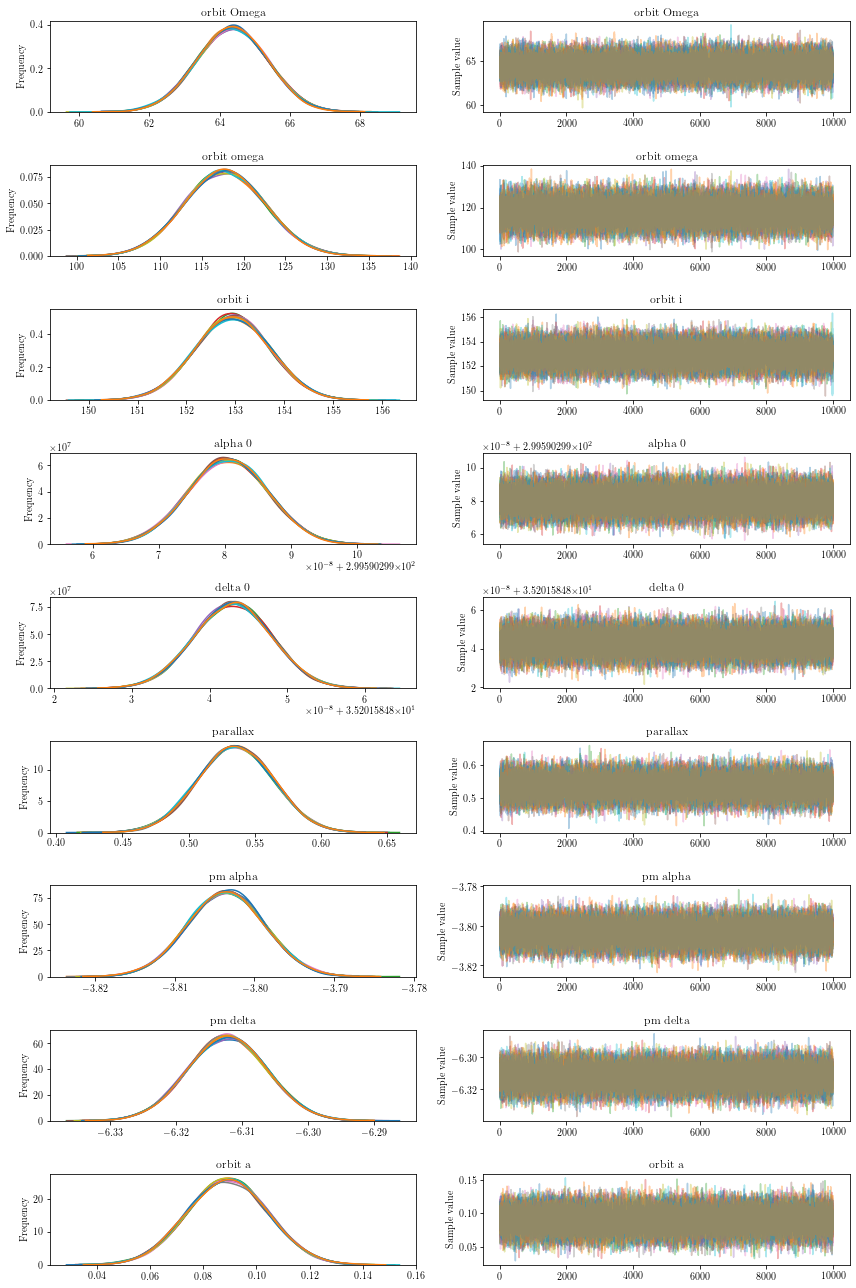

In [6]:
# Initial guess values for alpha_0 and delta_0:
ra_0_guess = observation_alpha.mean()
dec_0_guess = observation_delta.mean()

direct_model = pm.Model()
with direct_model:
    # Priors:
    alpha_0_prior = pm.Uniform('alpha 0',lower=ra_0_guess-0.2/3600, upper=ra_0_guess+0.2/3600)    # In degrees
    delta_0_prior = pm.Uniform('delta 0',lower=dec_0_guess-0.2/3600, upper=dec_0_guess+0.2/3600)  # In degrees
    parallax_prior = pm.Uniform('parallax', lower=0.1, upper=0.9)                                 # In milliarcsec
    pm_alpha_prior = pm.Uniform('pm alpha', lower=-20.0, upper=20.0)                              # In milliarcsec/yr
    pm_delta_prior = pm.Uniform('pm delta', lower=-20.0, upper=20.0)                              # In milliarcsec/yr
    orb_Omega_prior = pm.Normal('orbit Omega', mu=64.0, sd=1.0)                                   # In degrees
    orb_a_prior = pm.Uniform('orbit a', lower=0.0, upper=0.5)                                     # In milliarcsec
    orb_omega_prior = pm.Normal('orbit omega', mu=127.6, sd=5.3)                                  # In degrees
    orb_i_prior = pm.Normal('orbit i', mu=152.94, sd=0.76)                                        # In degrees
    
    # Values known with high precision:
    orb_P_val = 5.599829                           # in days
    orb_T_0_val = 41163.029+(0.109*orb_P_val)      # MJD
    orb_e_val = 0.018                              # unitless
    
    # Expected values for RA and Dec:
    expected_ra, expected_dec = total_motion(t = observation_t,
                                             alpha = observation_alpha,
                                             delta = observation_delta,
                                             alpha_0 = alpha_0_prior,
                                             delta_0 = delta_0_prior,
                                             pm_alpha = pm_alpha_prior,
                                             pm_delta = pm_delta_prior,
                                             parallax = parallax_prior,
                                             orb_T_0 = orb_T_0_val,
                                             orb_P = orb_P_val,
                                             orb_e = orb_e_val,
                                             orb_i = orb_i_prior,
                                             orb_omega = orb_omega_prior,
                                             orb_Omega = orb_Omega_prior,
                                             orb_a = orb_a_prior)

    # Observed quantities:
    fitting_ra = pm.Normal('ra', mu = expected_ra, 
                           sd = observation_alpha_obs_er, 
                           observed = observation_alpha * np.cos(np.radians(observation_delta)))
    
    fitting_dec = pm.Normal('dec', mu = expected_dec, 
                            sd = observation_delta_obs_er, 
                            observed = observation_delta)

    # Sampling:
    if saving:
        db1 = pm.backends.Text('./results/'+prefix+'trace_db_model1_standardfit')
        step_method = pm.NUTS()
        trace1 = pm.sample(10000, chains=12, cores=12, tune=2000, random_seed=rand_seed, step=step_method, trace=db1)
    elif past_chains:
        trace1 = pm.backends.text.load('../current/results/'+prefix+'trace_db_model1_standardfit')[2000:]
    else:
        step_method = pm.NUTS()
        trace1 = pm.sample(10000, chains=12, cores=12, tune=2000, random_seed=rand_seed, step=step_method)


pm.traceplot(trace1)
if saving:
    plt.savefig('./results/'+prefix+'model1_standardfit_traces.pdf')
pm.summary(trace1)

### Results for model 1

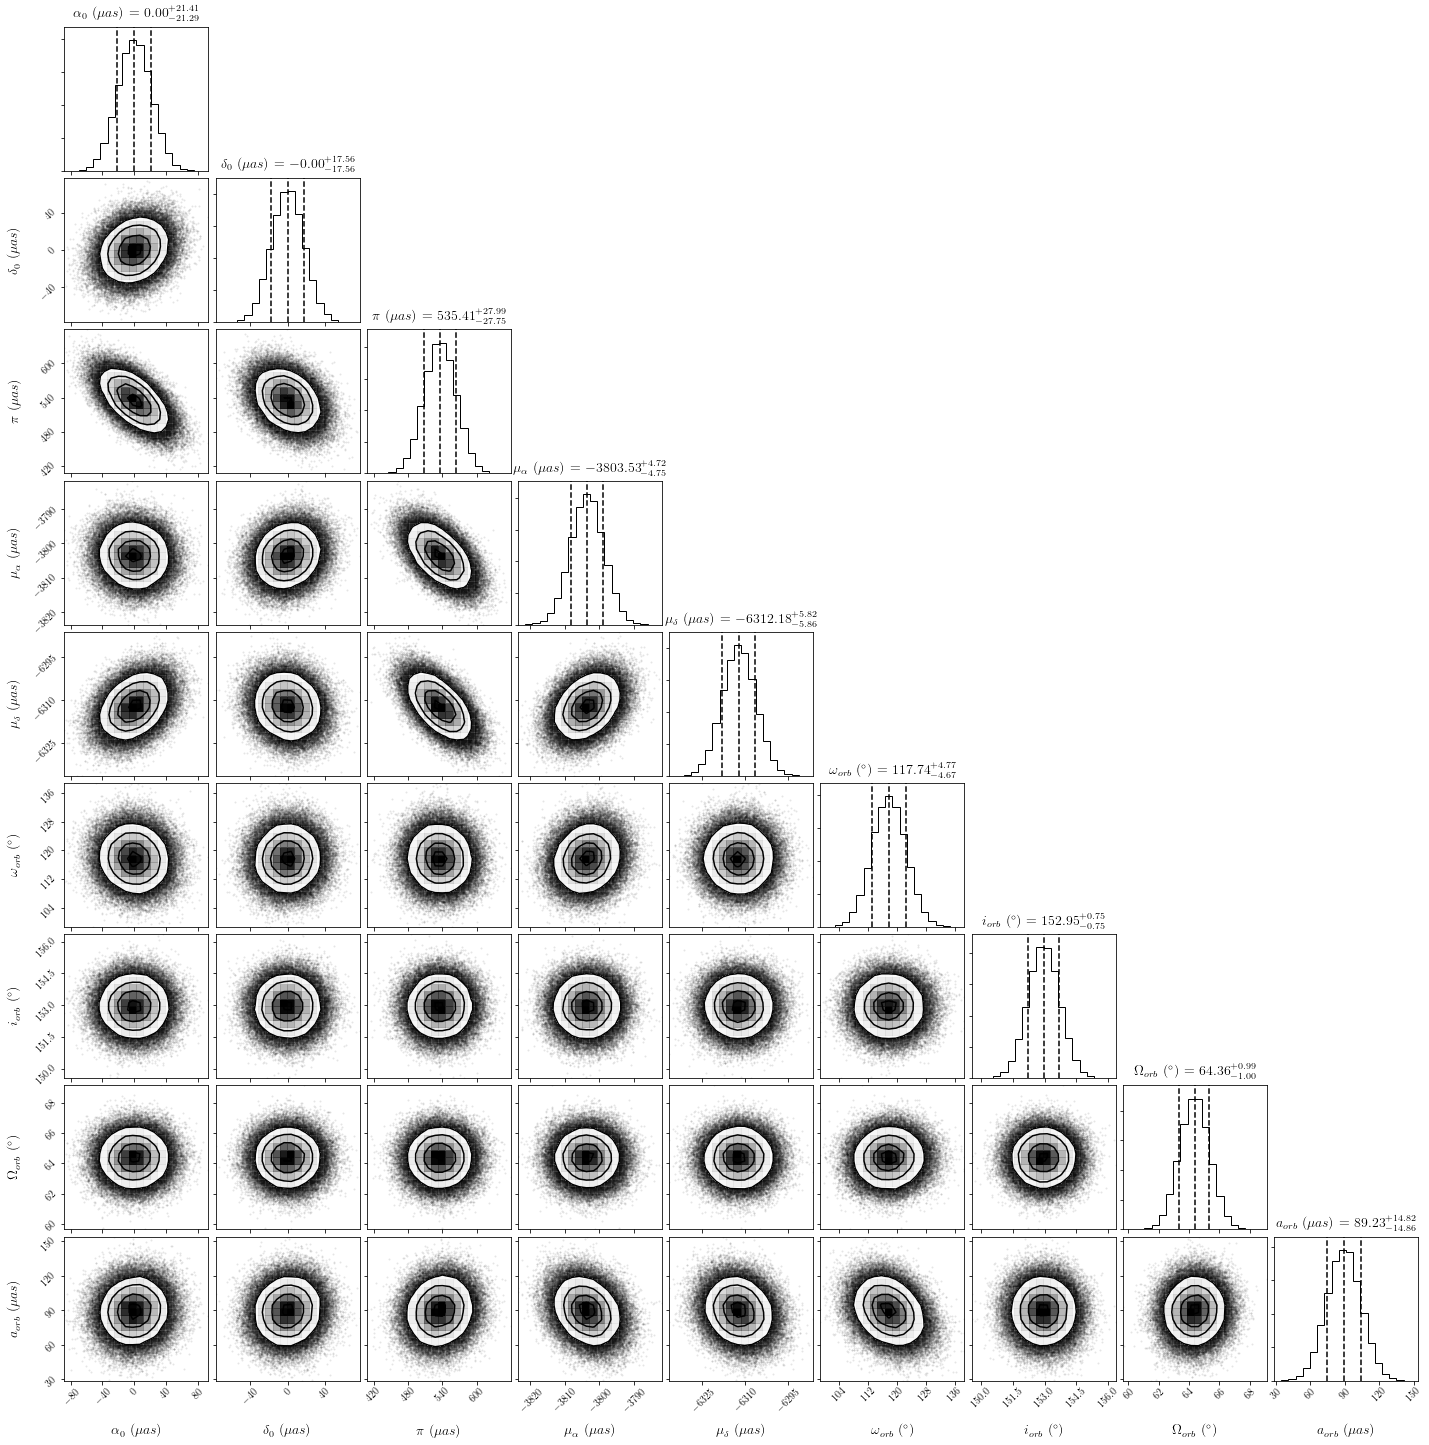

In [7]:
corner_data = list(zip(*np.array([(trace1.get_values('alpha 0') - np.median(trace1.get_values('alpha 0')))*3.6e9,
                                  (trace1.get_values('delta 0') - np.median(trace1.get_values('delta 0')))*3.6e9,
                                  trace1.get_values('parallax')*1e3,
                                  trace1.get_values('pm alpha')*1e3,
                                  trace1.get_values('pm delta')*1e3,
                                  trace1.get_values('orbit omega'),
                                  trace1.get_values('orbit i'),
                                  trace1.get_values('orbit Omega'),
                                  trace1.get_values('orbit a')*1e3])))

cornplot = corner.corner(corner_data,quantiles=[0.16,0.5,0.84],show_titles=True,use_math_text=False,
                         labels = [r'$\alpha_0~(\mu as)$', r'$\delta_0~(\mu as)$', r'$\pi~(\mu as)$',
                                   r'$\mu_\alpha~(\mu as)$', r'$\mu_\delta~(\mu as)$',
                                   r'$\omega_{orb}~(^{\circ})$',r'$i_{orb}~(^{\circ})$',
                                   r'$\Omega_{orb}~(^{\circ})$', r'$a_{orb}~(\mu as)$'],
                         title_kwargs={"fontsize": 14},label_kwargs={"fontsize": 14})

if saving:
    cornplot.savefig('./results/'+prefix+'model1_standardfit_corner.pdf',bbos_inches='tight')

/home/arash/anaconda3/lib/python3.6/site-packages/pymc3/stats.py:982: FutureWarning: The join_axes-keyword is deprecated. Use .reindex or .reindex_like on the result to achieve the same functionality.
  axis=1, join_axes=[dforg.index])


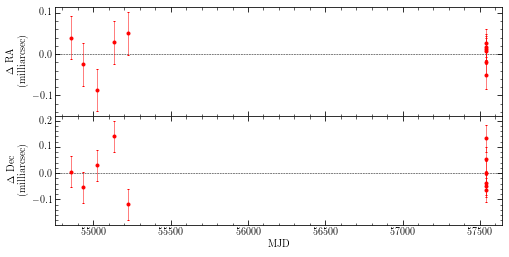

In [8]:
results = total_motion(t = observation_t,
                       alpha = observation_alpha,
                       delta = observation_delta,
                       alpha_0 = pm.summary(trace1)['mean']['alpha 0'],
                       delta_0 = pm.summary(trace1)['mean']['delta 0'],
                       pm_alpha = pm.summary(trace1)['mean']['pm alpha'],
                       pm_delta = pm.summary(trace1)['mean']['pm delta'],
                       parallax = pm.summary(trace1)['mean']['parallax'],
                       orb_T_0 = orb_T_0_val,
                       orb_P = orb_P_val,
                       orb_e = orb_e_val,
                       orb_i = pm.summary(trace1)['mean']['orbit i'],
                       orb_omega = pm.summary(trace1)['mean']['orbit omega'],
                       orb_Omega = pm.summary(trace1)['mean']['orbit Omega'],
                       orb_a = pm.summary(trace1)['mean']['orbit a'])

xmin, xmax = observation_t.min() - 100, observation_t.max() + 100

plt.figure(figsize=(8,4))
plt.subplot2grid((2,1),(0,0))
plt.hlines(0,xmin, xmax,colors='k',linestyles='--', linewidth=0.5)
plt.errorbar(observation_t,
             (observation_alpha * np.cos(np.radians(observation_delta)) - results[0])*3.6e6,
             observation_alpha_obs_er*3.6e6,
             fmt='.r', capsize=1, elinewidth=0.5)
plt.xlim(xmin, xmax)
plt.ylabel('$\Delta$ RA\n(milliarcsec)')
plt.gca().axes.set_xticklabels([])
plt.minorticks_on()
plt.tick_params(axis='both', which='major', labelsize=10)
plt.tick_params(axis='both', which='major', length=5)
plt.tick_params(axis='both', which='minor', length=2.5)
plt.tick_params(axis='both', which='both',direction='in',right=True,top=True)

plt.subplot2grid((2,1),(1,0))
plt.hlines(0,xmin, xmax,colors='k',linestyles='--', linewidth=0.5)
plt.errorbar(observation_t,
             (observation_delta - results[1])*3.6e6, 
             observation_delta_obs_er*3.6e6,
             fmt='.r', capsize=1, elinewidth=0.5)
plt.xlim(xmin, xmax)
plt.xlabel('MJD')
plt.ylabel('$\Delta$ Dec\n(milliarcsec)')
plt.minorticks_on()
plt.tick_params(axis='both', which='major', labelsize=10)
plt.tick_params(axis='both', which='major', length=5)
plt.tick_params(axis='both', which='minor', length=2.5)
plt.tick_params(axis='both', which='both',direction='in',right=True,top=True)
plt.subplots_adjust(wspace=0.0, hspace=0.0)
if saving:
    plt.savefig('./results/'+prefix+'model1_standardfit_residuals.pdf')

## Model 2: 1-D fit - One-dimensional fit perpendicular to the jet axis

### Model setup
Given possible contamination of the radio jet on source position estimates, we project $\alpha$ and $\delta$ on components perpendicular and parallel to the jet:

$$ \theta_\perp = \alpha \cos \beta +\delta \sin \beta $$
$$ \theta_\parallel = \delta \cos \beta - \alpha \sin \beta $$

Where $\beta$ is the angle axis orientation on the plane of the sky (CW from N).

To avoid contamination from the jet, we only consider $\theta_\perp$:

$$ p(\alpha_0,\delta_0,\pi,\mu_\alpha, \mu_\delta, a, \Omega~|~t, \alpha_t, \theta_{\perp,t}, \sigma_{\theta_\perp}) = p(\alpha_0,\delta_0,\pi,\mu_\alpha, \mu_\delta, a, \Omega)~p(\theta_{\perp,t}~|~t, \sigma_{\theta_\perp}, \alpha_0,\delta_0,\pi,\mu_\alpha, \mu_\delta, a, \Omega) $$

Where:
$$ \sigma_{\theta_\perp} = \sqrt{\sigma_\alpha^2 \cos^2\beta + \sigma_\delta^2 \sin^2\beta} $$

The jet angle for Cyg X1 is well-known, oriented at $-26^{\circ}$.

In [9]:
def jet_coordinates(alpha, delta, beta):
    """
    Applying a rotation matrix to transform ra and dec into parallel and perpendicular 
    to jet axis components.
    
    Parameters
    ----------
    alpha: Observation RA, an array, in degrees.
    
    delta: Observation Dec, an array, in degrees.

    beta: rotation angle (jet angle), in degrees.
    
    Returns
    -------    
    theta_perp, theta_para: rotated coordinates, perpendicular and parallel to the jet, respectively (in degrees).
    
    """
    beta_radian = np.radians(beta)
    theta_perp = alpha * np.cos(beta_radian) + delta * np.sin(beta_radian)
    theta_para = delta * np.cos(beta_radian) - alpha * np.sin(beta_radian)
    return theta_perp, theta_para


jet_angle = 26.0
theta_perp_t, theta_para_t = jet_coordinates(observation_alpha * np.cos(np.radians(observation_delta)), observation_delta, jet_angle)
theta_perp_er = np.sqrt((observation_alpha_obs_er * np.cos(np.radians(jet_angle)))**2 + (observation_delta_obs_er * np.sin(np.radians(jet_angle)))**2)
theta_para_er = np.sqrt((observation_alpha_obs_er * np.sin(np.radians(jet_angle)))**2 + (observation_delta_obs_er * np.cos(np.radians(jet_angle)))**2)


**We set the priors for RA, Dec and proper motion based on posteriors in model 1**. 

$\alpha_0$,$\delta_0$,and $\mu_\alpha$, $\mu_\delta$ are strongly correlated and thus flat priors for all of these quantities when only fitting on one axis produces substantial degeneracies. Thus we adopt results from model 1 posteriors for these parameters as priors in this model (more accurately the mean and standard deviation values of posterior distributions, but given the posteriors look Gaussian, it seems appropriate).

/home/arash/anaconda3/lib/python3.6/site-packages/pymc3/stats.py:982: FutureWarning: The join_axes-keyword is deprecated. Use .reindex or .reindex_like on the result to achieve the same functionality.
  axis=1, join_axes=[dforg.index])


,mean,sd,mc_error,hpd_2.5,hpd_97.5,n_eff,Rhat
alpha 0,299.590299,5.956542e-09,1.682316e-11,299.590299,299.590299,109255.369256,0.999979
pm alpha,-3.803539,4.738069e-03,1.364456e-05,-3.812958,-3.794336,111721.993983,1.000012
orbit Omega,64.089568,9.955705e-01,2.772708e-03,62.121724,66.014428,122057.815912,0.999992
orbit omega,124.775983,5.180710e+00,1.468191e-02,114.585125,134.838750,126243.899803,1.000034
orbit i,152.943500,7.624914e-01,2.193703e-03,151.443723,154.433727,130756.394305,0.999990
delta 0,35.201585,1.678056e-08,5.626281e-11,35.201585,35.201585,89896.084391,0.999980
parallax,0.457939,3.532513e-02,1.210615e-04,0.387695,0.525828,96316.155758,0.999990
pm delta,-6.283328,1.749197e-02,5.352942e-05,-6.317822,-6.249326,91587.254256,1.000014
orbit a,0.057988,1.959662e-02,5.769322e-05,0.019723,0.096560,97336.083845,0.999995


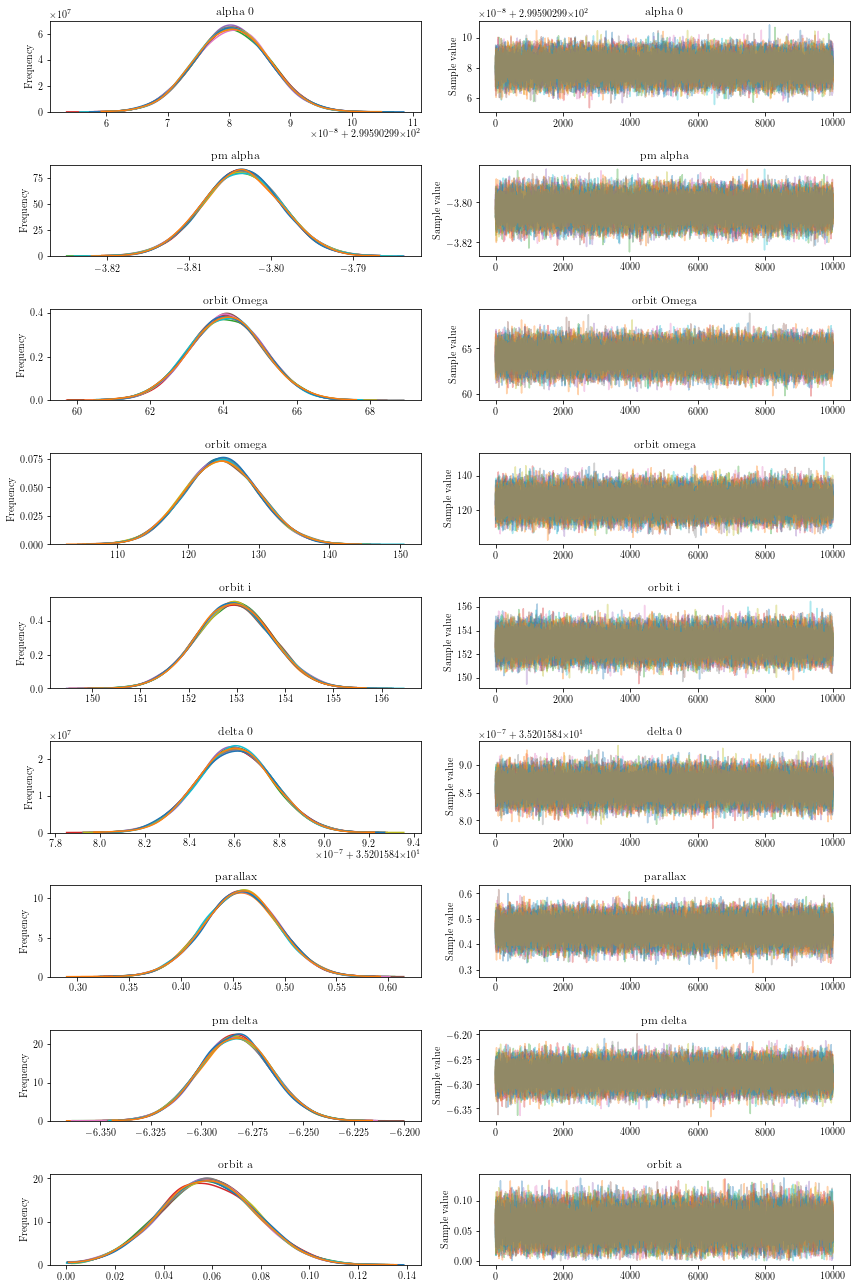

In [10]:
projection_model = pm.Model()
with projection_model:
    # Priors for unknown model parameters
    alpha_0_prior = pm.Normal('alpha 0',
                              mu=trace1.get_values('alpha 0').mean(),
                              sd=trace1.get_values('alpha 0').std())                        # In degrees
    delta_0_prior = pm.Uniform('delta 0',
                               lower=trace1.get_values('delta 0').mean()-0.001/3600, 
                               upper=trace1.get_values('delta 0').mean()+0.001/3600)        # In degrees
    parallax_prior = pm.Uniform('parallax', lower=0.1, upper=0.9)                           # In milliarcsec
    pm_alpha_prior = pm.Normal('pm alpha', 
                               mu=trace1.get_values('pm alpha').mean(),
                               sd=trace1.get_values('pm alpha').std())                      # In milliarcsec/yr
    pm_delta_prior = pm.Uniform('pm delta', lower=-7.0, upper=-2.0)                         # In milliarcsec/yr
    orb_Omega_prior = pm.Normal('orbit Omega', mu=64.0, sd=1.0)                             # In degrees
    orb_a_prior = pm.Uniform('orbit a', lower =0.0, upper=0.5)                              # In milliarcsec
    orb_omega_prior = pm.Normal('orbit omega', mu=127.6, sd=5.3)                            # In degrees
    orb_i_prior = pm.Normal('orbit i', mu=152.94, sd=0.76)                                  # In degrees

    # Values known with high precision:
    orb_P_val = 5.599829                           # in days
    orb_T_0_val = 41163.029+(0.109*orb_P_val)      # MJD
    orb_e_val = 0.018                              # unitless
    
    # Expected values for RA and Dec:
    expected_ra, expected_dec = total_motion(t = observation_t,
                                             alpha = observation_alpha,
                                             delta = observation_delta,
                                             alpha_0 = alpha_0_prior,
                                             delta_0 = delta_0_prior,
                                             pm_alpha = pm_alpha_prior,
                                             pm_delta = pm_delta_prior,
                                             parallax = parallax_prior,
                                             orb_T_0 = orb_T_0_val,
                                             orb_P = orb_P_val,
                                             orb_e = orb_e_val,
                                             orb_i = orb_i_prior,
                                             orb_omega = orb_omega_prior,
                                             orb_Omega = orb_Omega_prior,
                                             orb_a = orb_a_prior)

        
    expected_theta_perp, expected_theta_para = jet_coordinates(expected_ra, expected_dec, jet_angle)
    
    # Observed quantities:  
    fitting_theta_perp = pm.Normal('theta_perp', mu = expected_theta_perp,
                                   sd = theta_perp_er,
                                   observed = theta_perp_t)
    
    # Sampling:
    if saving:
        db3 = pm.backends.Text('./results/'+prefix+'trace_db_model2_1dfit')
        step_method = pm.NUTS()
        trace3 = pm.sample(10000, chains=12, cores=12, tune=5000, random_seed=rand_seed, step=step_method, trace=db3)
    elif past_chains:
        trace3 = pm.backends.text.load('../current/results/'+prefix+'trace_db_model2_1dfit')[5000:]
    else:
        step_method = pm.NUTS()
        trace3 = pm.sample(10000, chains=12, cores=12, tune=5000, random_seed=rand_seed, step=step_method)
        

pm.traceplot(trace3);
if saving:
    plt.savefig('./results/'+prefix+'model2_1dfit_traces.pdf')
pm.summary(trace3).round(20)

### Results for model 2

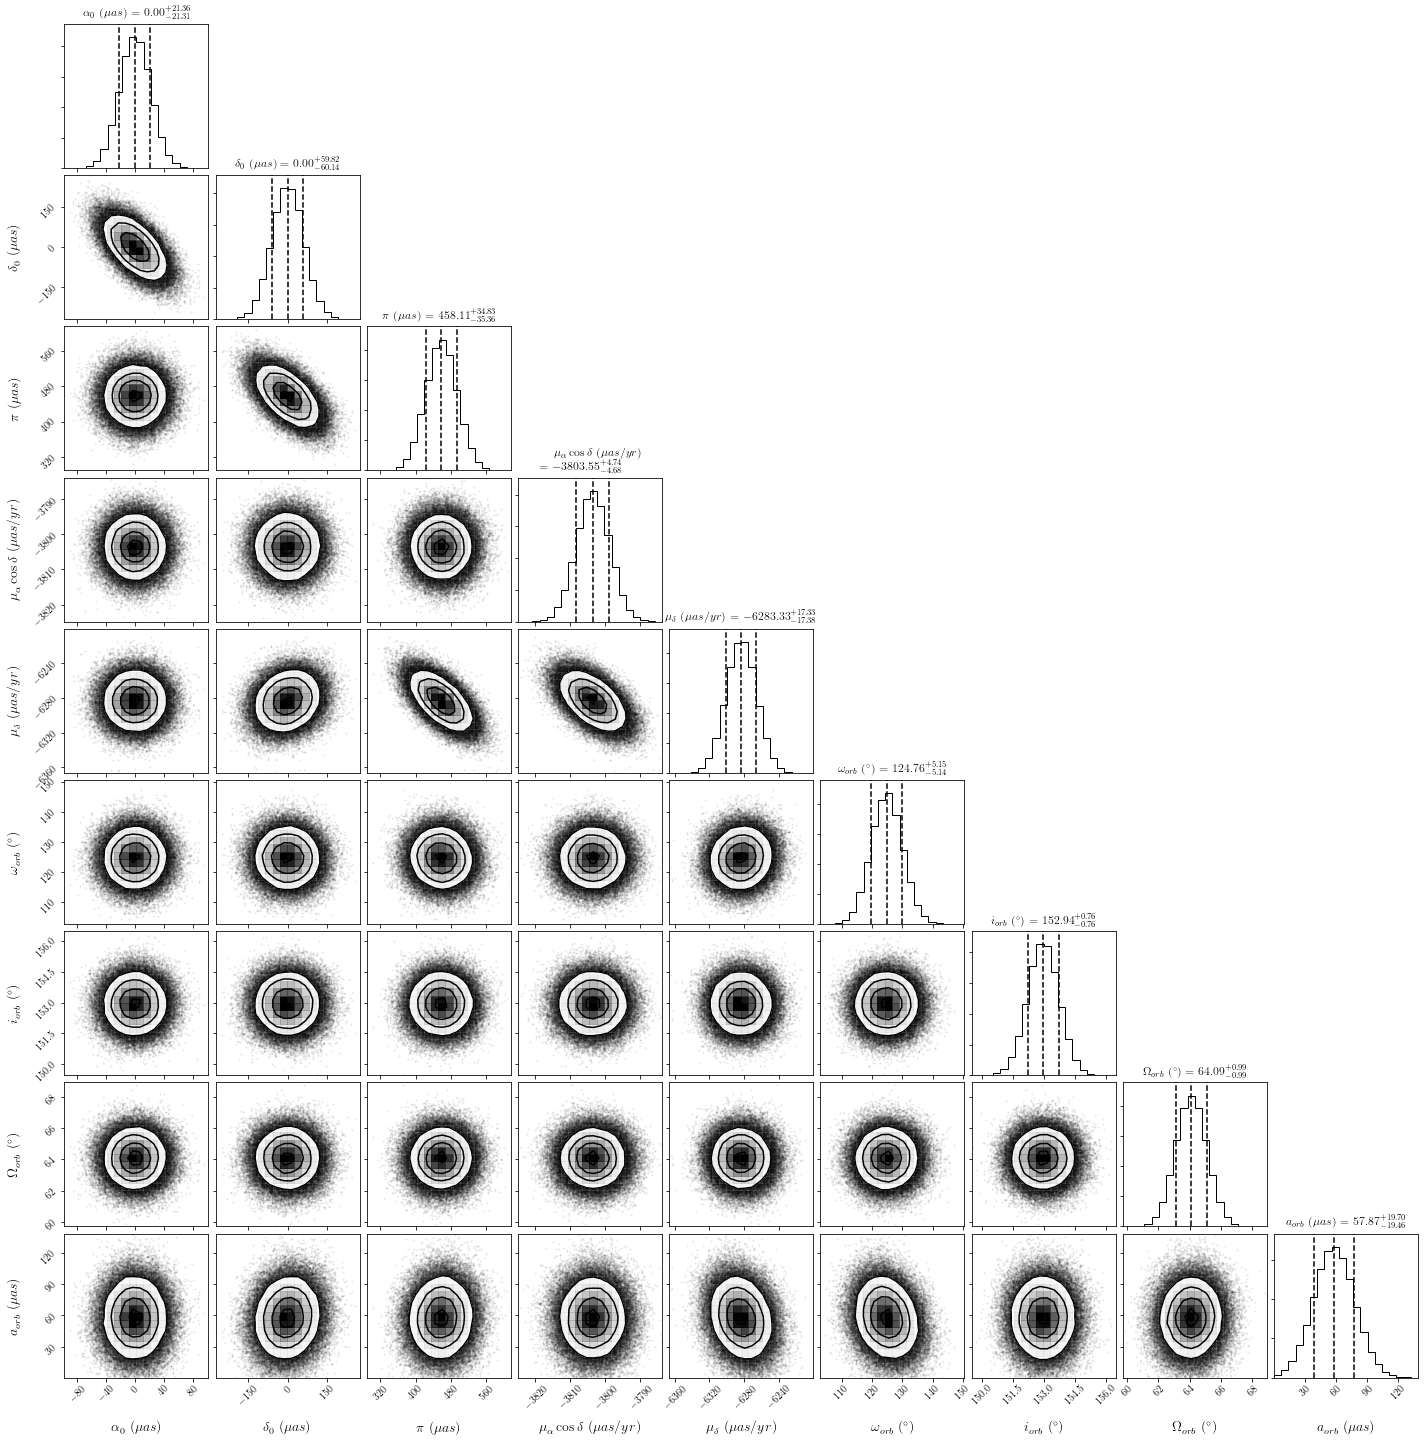

In [11]:
corner_data = list(zip(*np.array([(trace3.get_values('alpha 0') - np.median(trace3.get_values('alpha 0')))*3.6e9,
                                  (trace3.get_values('delta 0') - np.median(trace3.get_values('delta 0')))*3.6e9,
                                  trace3.get_values('parallax')*1e3,
                                  trace3.get_values('pm alpha')*1e3,
                                  trace3.get_values('pm delta')*1e3,
                                  trace3.get_values('orbit omega'),
                                  trace3.get_values('orbit i'),
                                  trace3.get_values('orbit Omega'),
                                  trace3.get_values('orbit a')*1e3])))

cornplot = corner.corner(corner_data,quantiles=[0.16,0.5,0.84],show_titles=True,use_math_text=False,
                         labels = [r'$\alpha_0~(\mu as)$', r'$\delta_0~(\mu as)$', r'$\pi~(\mu as)$',
                                   r'$\mu_\alpha \cos\delta~(\mu as/yr)$\\', r'$\mu_\delta~(\mu as/yr)$',
                                   r'$\omega_{orb}~(^{\circ})$',r'$i_{orb}~(^{\circ})$',
                                   r'$\Omega_{orb}~(^{\circ})$', r'$a_{orb}~(\mu as)$'],
                         title_kwargs={"fontsize": 12},label_kwargs={"fontsize": 14})

#cornplot.set_figheight(9)
#cornplot.set_figwidth(9)
if saving:
    cornplot.savefig('./results/'+prefix+'model2_1dfit_corner.pdf',bbos_inches='tight')

#cornplot.savefig('./results/'+prefix+'model2_1dfit_corner_new.pdf',bbos_inches='tight')

/home/arash/anaconda3/lib/python3.6/site-packages/pymc3/stats.py:982: FutureWarning: The join_axes-keyword is deprecated. Use .reindex or .reindex_like on the result to achieve the same functionality.
  axis=1, join_axes=[dforg.index])


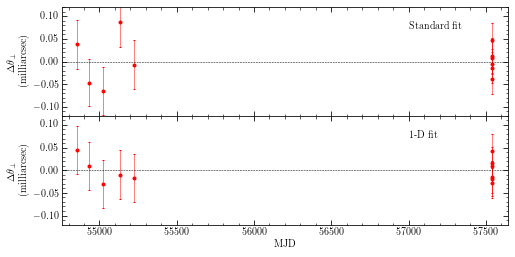

In [12]:
model_test_ra1, model_test_dec1 = total_motion(t = observation_t,
                                               alpha = observation_alpha,
                                               delta = observation_delta,
                                               alpha_0 = pm.summary(trace1)['mean']['alpha 0'],
                                               delta_0 = pm.summary(trace1)['mean']['delta 0'],
                                               pm_alpha = pm.summary(trace1)['mean']['pm alpha'],
                                               pm_delta = pm.summary(trace1)['mean']['pm delta'],
                                               parallax = pm.summary(trace1)['mean']['parallax'],
                                               orb_T_0 = orb_T_0_val,
                                               orb_P = orb_P_val,
                                               orb_e = orb_e_val,
                                               orb_i = pm.summary(trace1)['mean']['orbit i'],
                                               orb_omega = pm.summary(trace1)['mean']['orbit omega'],
                                               orb_Omega = pm.summary(trace1)['mean']['orbit Omega'],
                                               orb_a = pm.summary(trace1)['mean']['orbit a'])

model_test_ra2, model_test_dec2 = total_motion(t = observation_t,
                                               alpha = observation_alpha,
                                               delta = observation_delta,
                                               alpha_0 = pm.summary(trace3)['mean']['alpha 0'],
                                               delta_0 = pm.summary(trace3)['mean']['delta 0'],
                                               pm_alpha = pm.summary(trace3)['mean']['pm alpha'],
                                               pm_delta = pm.summary(trace3)['mean']['pm delta'],
                                               parallax = pm.summary(trace3)['mean']['parallax'],
                                               orb_T_0 = orb_T_0_val,
                                               orb_P = orb_P_val,
                                               orb_e = orb_e_val,
                                               orb_i = pm.summary(trace3)['mean']['orbit i'],
                                               orb_omega = pm.summary(trace3)['mean']['orbit omega'],
                                               orb_Omega = pm.summary(trace3)['mean']['orbit Omega'],
                                               orb_a = pm.summary(trace3)['mean']['orbit a'])

model_test_theta_perp1, model_test_theta_para1 = jet_coordinates(model_test_ra1, model_test_dec1, jet_angle)
model_test_theta_perp2, model_test_theta_para2 = jet_coordinates(model_test_ra2, model_test_dec2, jet_angle)

plt.figure(figsize=(8,4))
plt.subplot2grid((2,1),(0,0))
plt.errorbar(observation_t, (theta_perp_t-model_test_theta_perp1)*3.6e6, theta_perp_er*3.6e6,
             fmt='.r', capsize=1, elinewidth=0.5)
plt.text(57000,0.07,'Standard fit')
plt.xlim(xmin, xmax)
plt.ylim(-0.12,0.12)
plt.hlines(0,xmin, xmax,colors='k',linestyles='--', linewidth=0.5)
plt.xlabel('MJD')
plt.ylabel(r'$\Delta\theta_\perp$ \\(milliarcsec)')
plt.minorticks_on()
plt.tick_params(axis='both', which='major', labelsize=10)
plt.tick_params(axis='both', which='major', length=5)
plt.tick_params(axis='both', which='minor', length=2.5)
plt.tick_params(axis='both', which='both',direction='in',right=True,top=True)

plt.subplot2grid((2,1),(1,0))
plt.errorbar(observation_t, (theta_perp_t-model_test_theta_perp2)*3.6e6, theta_perp_er*3.6e6,
             fmt='.r', capsize=1, elinewidth=0.5)
plt.text(57000,0.07,'1-D fit')
plt.xlim(xmin, xmax)
plt.ylim(-0.12,0.12)
plt.hlines(0,xmin, xmax,colors='k',linestyles='--', linewidth=0.5)
plt.xlabel('MJD')
plt.ylabel(r'$\Delta\theta_\perp$ \\(milliarcsec)')
plt.minorticks_on()
plt.tick_params(axis='both', which='major', labelsize=10)
plt.tick_params(axis='both', which='major', length=5)
plt.tick_params(axis='both', which='minor', length=2.5)
plt.tick_params(axis='both', which='both',direction='in',right=True,top=True)


plt.subplots_adjust(wspace=0.0, hspace=0.0)
if saving:
    plt.savefig('./results/'+prefix+'model2_1dfit_residuals.pdf')

## Producing and writing final reports:

In [13]:
def floatdigits(x):
    return str(np.round(x, decimals=20))

def trace_quantiles(x):
    return pd.DataFrame(pm.quantiles(x, [50]))

def trace_bci(x):
    return pd.DataFrame(pm.hpd(x,alpha=0.1),columns=['5%-BCI','95%-BCI'])

#def trace_rhat(x):
#    return pd.DataFrame(pm.gelman_rubin(x))

if saving:
    pm.summary(trace1, stat_funcs=[trace_quantiles,trace_bci]).round(20).to_latex('./results/'+prefix+'model1_standardfit_results_table.tex', float_format=floatdigits)
    pm.summary(trace3, stat_funcs=[trace_quantiles,trace_bci]).round(20).to_latex('./results/'+prefix+'model2_1dfit_results_table.tex', float_format=floatdigits)

## Comparisons

We compare 1-D fit with the normal fit. We are going to use the [GetDist](https://getdist.readthedocs.io/en/latest/) package for plotting comparisons.

Removed no burn in
Removed no burn in


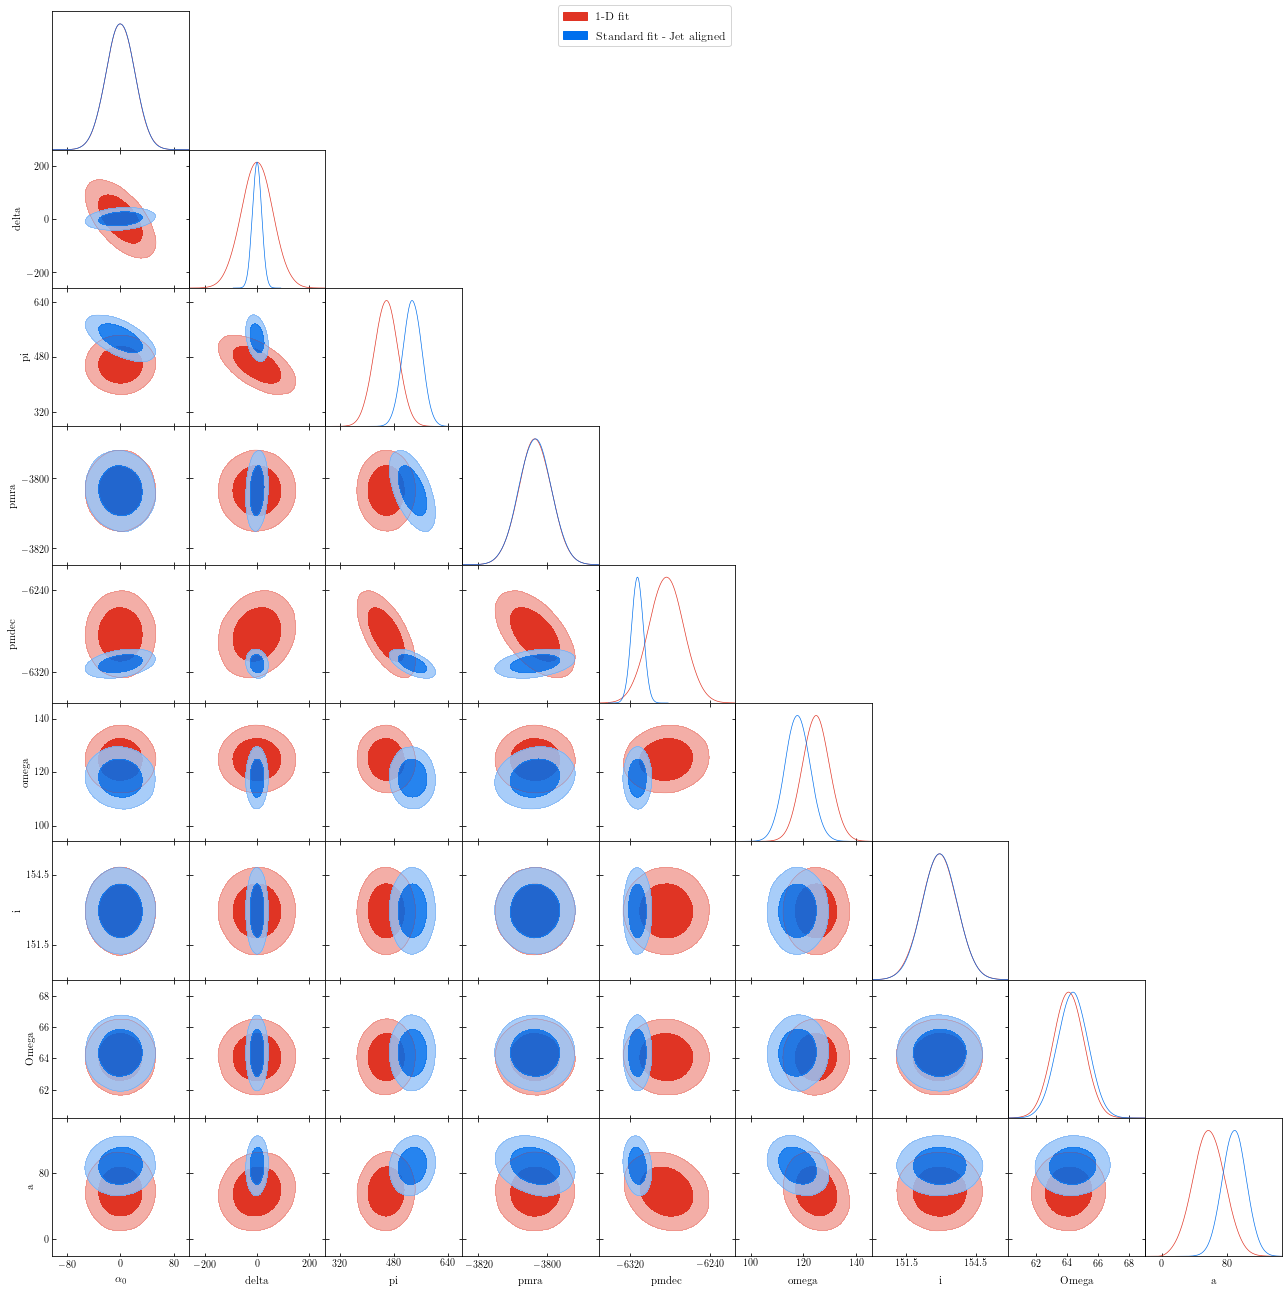

In [14]:
from getdist import plots, MCSamples

parnames = [r'$\alpha_0$','delta','pi','pmra','pmdec','omega','i','Omega','a']

s1 = MCSamples(samples=np.array(list(zip(*np.array([(trace1.get_values('alpha 0') - np.median(trace1.get_values('alpha 0')))*3.6e9,
                                  (trace1.get_values('delta 0') - np.median(trace1.get_values('delta 0')))*3.6e9,
                                  trace1.get_values('parallax')*1e3,
                                  trace1.get_values('pm alpha')*1e3,
                                  trace1.get_values('pm delta')*1e3,
                                  trace1.get_values('orbit omega'),
                                  trace1.get_values('orbit i'),
                                  trace1.get_values('orbit Omega'),
                                  trace1.get_values('orbit a')*1e3])))),
               names = parnames,
               label='Standard fit - Jet aligned'
              )

s3 = MCSamples(samples=np.array(list(zip(*np.array([(trace3.get_values('alpha 0') - np.median(trace3.get_values('alpha 0')))*3.6e9,
                                  (trace3.get_values('delta 0') - np.median(trace3.get_values('delta 0')))*3.6e9,
                                  trace3.get_values('parallax')*1e3,
                                  trace3.get_values('pm alpha')*1e3,
                                  trace3.get_values('pm delta')*1e3,
                                  trace3.get_values('orbit omega'),
                                  trace3.get_values('orbit i'),
                                  trace3.get_values('orbit Omega'),
                                  trace3.get_values('orbit a')*1e3])))),
               names = parnames,
               label='1-D fit'
              )

g = plots.getSubplotPlotter()
g.triangle_plot([s3, s1], filled=True)
if saving:
    g.export('./results/'+prefix+'_model_comparision.pdf')